# Flat analysis

We load the standard packages for data analysis and plotting \
[NumPy](https://numpy.org/) \
[Matplotlib](https://matplotlib.org/) \
[AstroPy](https://docs.astropy.org/en/stable/index.html) \
[pickle](https://docs.python.org/3/library/pickle.html) 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pickle

%matplotlib widget

We read the list of bias frames in the usual way:

In [2]:
flat_list = np.genfromtxt('../flat/flat.list', dtype=str)
print(flat_list)

['AF580626.fits' 'AF580627.fits' 'AF580628.fits' 'AF580629.fits'
 'AF580630.fits' 'AF580631.fits' 'AF580632.fits' 'AF580633.fits'
 'AF580634.fits' 'AF580635.fits' 'AF580636.fits' 'AF580637.fits'
 'AF580638.fits' 'AF580639.fits' 'AF580640.fits' 'AF580641.fits'
 'AF580642.fits' 'AF580643.fits' 'AF580644.fits' 'AF580645.fits'
 'AF580646.fits' 'AF580647.fits' 'AF580648.fits' 'AF580649.fits'
 'AF580650.fits' 'AF580651.fits' 'AF580652.fits' 'AF580653.fits'
 'AF580654.fits' 'AF580655.fits']


We also need to open the median bias and copy the estimates for the error associated with the bias and the readout noise obtained when analyzing the bias frames.
For this example, I will use the following values from the `lecture01_bias_analysis` Jupyter Notebook:
- `bias_std`: Median STD of each pixel
- `readout_noise`: STD single frame
- `gain`: as extracted from the header of a bias frame

In [3]:
median_bias = pickle.load(open("output_files/median_bias.p", "rb"))
bias_std = 1.3 # [e] photoelectrons
readout_noise = 7.4  # [e] photoelectrons
gain = 1.91 # [e/ADU]

For illustration purposes, I am opening the first flat frame and extracting the data. \
As a safety check, I'm also printing a few values from the header, directly from the first HDU. \
Notice how I condensed in one single call all the several steps that I had to do to go from the fits file to the header and header comments

In [4]:
flat00_fits = fits.open('../flat/'+flat_list[0])
flat00_data = flat00_fits[0].data * gain

print('CCD Gain         : {0:4.2f} {1:.8s}'.format(flat00_fits[0].header['GAIN'],flat00_fits[0].header.comments['GAIN']))
print('CCD Readout noise: {0:4.2f} {1:.3s}'.format(flat00_fits[0].header['RDNOISE'],flat00_fits[0].header.comments['RDNOISE']))
print('Shape of the FITS image from the header : {0:4d} x {1:4d} pixels'.format(flat00_fits[0].header['NAXIS1'], flat00_fits[0].header['NAXIS2']))


CCD Gain         : 1.91 [e/ADU] 
CCD Readout noise: 7.10 [e]
Shape of the FITS image from the header :  521 x  222 pixels


## Overscan

It's always a good idea to visually inspect your data.
If we let matplotlib choose the automatically the range of the colorbar, and we plot the average distribution of counts as a function of the column number, we can see that there are two strips on the side of the image with a much lower number of counts. Each column takes the name of **overscan**.




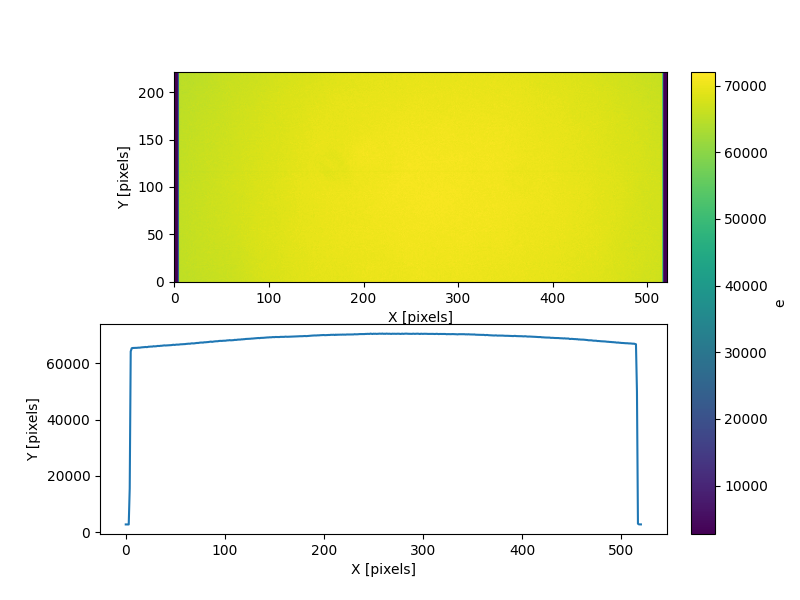

In [5]:
fig, ax = plt.subplots(2,1, figsize=(8,6)) # Caution, figsize will also influence positions.
im1 = ax[0].imshow(flat00_data, origin='lower')
median_column = np.average(flat00_data, axis=0)
im2 = ax[1].plot(median_column)

# add the colorbar using the figure's method,
# telling which mappable we're talking about and
# which axes object it should be near
cbar = fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("e")

ax[0].set_xlabel('X [pixels]')
ax[0].set_ylabel('Y [pixels]')

ax[1].set_xlabel('X [pixels]')
ax[1].set_ylabel('Y [pixels]')
plt.show()

The overscan region of a CCD is a part of the sensor that is covered, i.e., is not receiving any light. Depending on the sensor, it can be a valuable way to remove small variations in the bias level from frame to frame. Alternatively, you can use it to remove the bias level when the bias frames are not available. 

Generally speaking, you can replace the median bias with the overscan only if there is no variation along the horizontal axis, otherwise it is preferable to use the median bias, if available,  as in our case



## Properly dealing with the full frame

The overscan regions have no impact on our data reduction and science analysis, but their presence is annoying when performing statistics on the full frame or displaying the frame itself. There are (at least) two ways to deal with this problem:
1) We can trim the outer columns from all images and save the trimmed frames as new frames.
2) we can exclude the outer columns from the analysis when computing full-frame statistics and visualization
The first approach is well-diffused, but you need software that propagates the metadata (e.g., header, comments) into the new files. You also have to be sure to apply the same overscan cuts every time you reduce a new frame. You may also need extra space to store all the new images.
The second approach requires just a bit of attention.

Let's plot our frame again, but first, we compute the minimum and maximum values of our counts, excluding the overscan regions.

In [6]:
vmin = np.amin(flat00_data[:, 12:-12])
vmax = np.amax(flat00_data[:, 12:-12])
print(vmin, vmax)

64086.229999999996 72035.65


We do the plot again, but this time:
1) we set the limits for the colorbar in `ax[0].imshow()`
2) we set the limits for the vertical axis of the lower plot using `ax[1].set_ylim()`

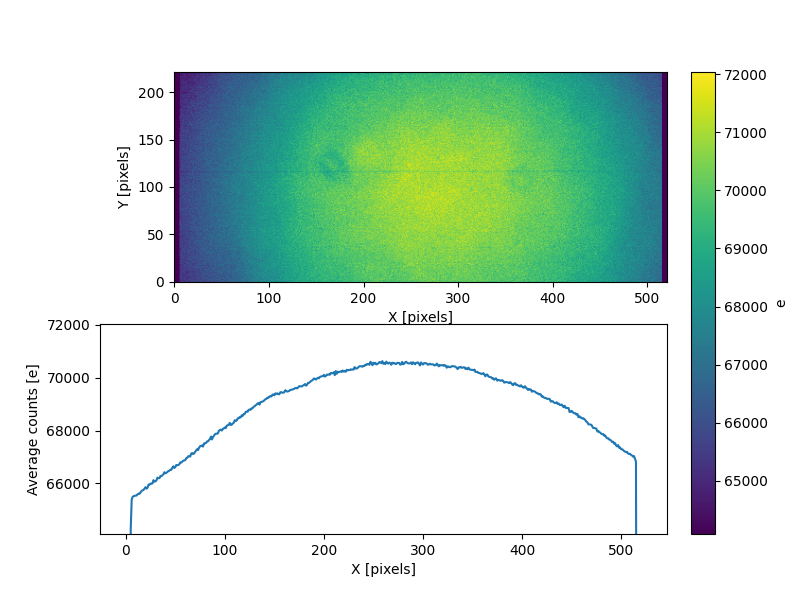

In [7]:
fig, ax = plt.subplots(2,1, figsize=(8,6)) # Caution, figsize will also influence positions.
im1 = ax[0].imshow(flat00_data, origin='lower', vmin=vmin, vmax=vmax)
median_column = np.average(flat00_data, axis=0)
im2 = ax[1].plot(median_column)

# we set the plot limits 
ax[1].set_ylim(vmin,vmax)

# add the colorbar using the figure's method,
# telling which mappable we're talking about and
# which axes object it should be near
cbar = fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("e")

ax[0].set_xlabel('X [pixels]')
ax[0].set_ylabel('Y [pixels]')

ax[1].set_xlabel('X [pixels]')
ax[1].set_ylabel('Average counts [e]')
plt.show()

## Computing the median flat

Computation of the median flat follows a similar strategy adopted for the median bias:
1) we initialize a 3D array called `stack`, with dimensions equal to the number of images and the two dimensions of a frame
2) we read the frames one by one, *correct for bias*, and store them in the `stack`
 

In [8]:
n_images = len(flat_list)
flat00_nparray_dim00, flat00_nparray_dim01 = np.shape(flat00_data)

stack = np.empty([n_images, flat00_nparray_dim00, flat00_nparray_dim01])

for i_flat, flat_name in enumerate(flat_list):
    flat_temp = fits.open('../flat/'+flat_name)
    stack[i_flat,:,:] = flat_temp[0].data * flat_temp[0].header['GAIN'] - median_bias
    flat_temp.close()


Before continuing, we have to remember the goal of flat calibration. 

The purpose of flat corrections is to compensate for any non-uniformity in the response of the CCD to light. There can be several reasons for the non-uniform response across the detector:
- variations in the sensitivity of pixels in the detector.
- dust on either the filter or the glass window covering the detector.
- vignetting, a dimming in the corners of the image.
- anything else in the optical path that affects how much light reaches the sensor.

The fix for the non-uniformity is the same in all cases: take an image with uniform illumination and use that to measure the response of the CCD. 

When illuminating the CCD, we want to reach the highest signal-to-noise ratio for every pixel. As the photon noise goes with the square root of the flux, we need to reach very high counts (without reaching saturation). However, dividing the science frames by these very high counts would produce unrealistically small photoelectron fluxes. Since we are interested in the relative response of the pixels, i.e., how the pixels behave with respect to the others, and not to the absolute efficiency of each pixel, we can express the flat correction as the correction value relative to the median response over a selected sample of pixels.
e CCD.

We can compute the reference value of each frame by taking the median within a box of size 50x50 pixels in the centre of each frame. Keep in mind that this is only one of the many possible approaches.

**Note**: we convert the real number into integers using the function [numpy.int16](https://numpy.org/doc/stable/reference/arrays.scalars.html#numpy.int16)

In [9]:
windows_size = 50
# x0, x1, y0, y1 represents the coordinates of the four corners
x0 = np.int16(flat00_nparray_dim01/2 - windows_size/2)
x1 = np.int16(flat00_nparray_dim01/2 + windows_size/2)
y0 = np.int16(flat00_nparray_dim00/2 - windows_size/2)
y1 = np.int16(flat00_nparray_dim00/2 + windows_size/2)

print('Coordinates of the box: x0:{0}, x1:{1}, y0:{2}, y1:{3}'.format(x0, x1, y0, y1))


Coordinates of the box: x0:235, x1:285, y0:86, y1:136


To compute the normalization factor of each frame, we can rely again on the `axis` argument of the function [`numpy.median`](https://numpy.org/doc/stable/reference/generated/numpy.median.html). 

In the case of the bias frame, we wanted to compute the median across the 30 bias frames for each pixel of the sensor, so we set `axis=0`, and the output had the same size of a frame. Here, we want to compute the median of a given set of pixels for each frame, and the resulting array should have the same size of the number of frames. 

To accomplish this, it is sufficient to specify the two axis that we want to include in computing the median, using round parenthesis as in the example below. The median will be computed using all the values in the range `[y0:y1, x0:x1]` of each frame 

The data among round paranthesis is called *tuple*, and it is one of the four main data types of Python.  You can remoad more aboutt Ttuples he and allow  duplicate values. You can read more about tuples [here](https://www.w3schools.com/python/python_tuples.asp

In [10]:
normalization_factors = np.median(stack[:,y0:y1, x0:x1], axis=(1,2))
print('Number of normalization factors (must be the same as the number of frames): {0}'.format(np.shape(normalization_factors)))
print(normalization_factors)

Number of normalization factors (must be the same as the number of frames): (30,)
[68196.55   68455.355  68250.03   68366.54   68187.955  68451.0575
 68229.02   68429.0925 68293.96   68442.4625 68285.8425 68463.4725
 68244.7775 68437.6875 68240.48   68450.58   68311.15   68443.895
 68294.915  68372.27   68269.6075 68486.87   68321.655  68464.4275
 68322.1325 68500.24   68280.59   68482.095  68287.275  68507.88  ]


To normalize each frame by its corresponding normlization factor, we can proceed in two ways:
1) iterate along the frame, and perform the operation:

In [11]:
stack_normalized_iter =  stack * 0. #initialization of the output array
for i_flat in range(n_images):
    stack_normalized_iter[i_flat,:,:] = stack[i_flat,:,:] / normalization_factors[i_flat]


2) use the [broadcasting feature](https://numpy.org/doc/stable/user/basics.broadcasting.html). 

Broacasting allows arithmetic operation between arrays with different shapes. Subject to certain constraints, the smaller array is “broadcast” across the larger array so that they have compatible shape. 

Brodcasting starts with the trailing (i.e. rightmost) dimension and works its way left. As this is the opposite situation of our case (`normalization_factors` has the same dimension of the leftmost dimension of `stack`), we can fix nuisance by operating on the *transpose* of the `stack` array, and then by taking the transpose of the out to revert back to the original shape.
The transpose is computed by simplymadding `.T` at the end of a Numpy array

In [12]:
print("shape of stack array           : ", np.shape(stack))
print("shape of transposed stack array: ", np.shape(stack.T))

stack_normalized = np.multiply(stack.T, 1./normalization_factors).T 
## Alternative: stack_normalized = np.divide(stack.T, normalization_factors).T 
print("shape of normalized stack array: ", np.shape(stack_normalized))


shape of stack array           :  (30, 222, 521)
shape of transposed stack array:  (521, 222, 30)
shape of normalized stack array:  (30, 222, 521)


We can verify if the two methods deliver the same results by checking what is the maximum deviations between the two arrays, in absolute sense.

In [13]:
print("Maximum absolute difference between the two arrays: {0:2.2e}".format(np.max(np.abs(stack_normalized_iter-stack_normalized))))

Maximum absolute difference between the two arrays: 2.22e-16


The valiue is not zero due to the computer precision:
*Epsilon* describes the round-off error for a floating-point number with a certain amount of precision. It can be thought as the smallest number that can be addedo to 1.0 without changing its bits.


In [14]:
print(np.finfo(float).eps)

2.220446049250313e-16


Therefore, we can say that the two procedures produce identical results. 

We can finally compute the median normalized flat frame, and store it on the computer:

In [15]:
median_normalized_flat = np.median(stack_normalized, axis=0)

pickle.dump(median_normalized_flat, open("output_files/median_normalized_flat.p", "wb")) 
pickle.dump(stack_normalized, open("output_files/flat_normalized_stack.p", "wb")) 
pickle.dump(normalization_factors, open("output_files/flat_normalization_factors.p", "wb")) 
pickle.dump(stack, open("output_files/flat_stack.p", "wb")) 


64086.229999999996 72035.65


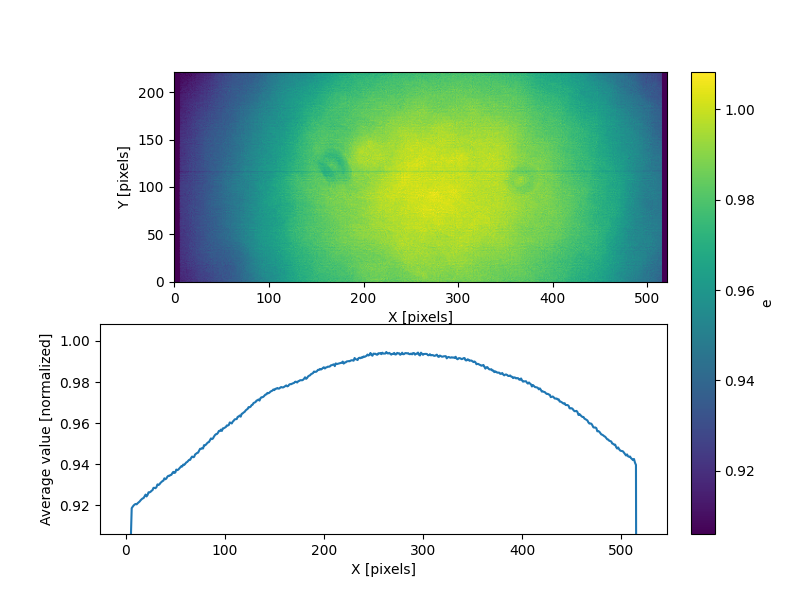

In [16]:
i_image = 0
nmin = np.amin(median_normalized_flat[:, 12:-12])
nmax = np.amax(median_normalized_flat[:, 12:-12])
print(vmin, vmax)


fig, ax = plt.subplots(2,1, figsize=(8,6)) # Caution, figsize will also influence positions.
im1 = ax[0].imshow(median_normalized_flat, origin='lower', vmin=nmin, vmax=nmax)
median_column = np.average(median_normalized_flat, axis=0)
im2 = ax[1].plot(median_column)

# we set the plot limits 
ax[1].set_ylim(nmin,nmax)

# add the colorbar using the figure's method,
# telling which mappable we're talking about and
# which axes object it should be near
cbar = fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("e")

ax[0].set_xlabel('X [pixels]')
ax[0].set_ylabel('Y [pixels]')

ax[1].set_xlabel('X [pixels]')
ax[1].set_ylabel('Average value [normalized]')
plt.show()

# Error propagation

In the case of the bias frames, the readout noise was the only contributor to the noise budget.
Now, we have three contributors:
1) the readout noise
2) the error associated to the median bias frame
3) the photon noise associated to the flux of the lamp
Dark current would contribute as well, but it can be neglected for short exposures and for modern detectors in general 

For 1) and 2) we have already an estimate of the error. For 3), we can assume that during the temporal interval covered by our exposure, photons reach the detector with a constant mean rate and independently of the time since the last event. (the arrival of one photon is not influenced by the other photons). In other words, photos follow a [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution), as such the *variance* (i.e., the expected value of the squared deviation from the mean of a random variable.) is equal to the number of events, specifically the number of photoelectrons recorded.

Noting that we have already removed the bias value (which does not contribute to the photon noise), the photon noise associated to each measurement of each frame is given by the square root of the stack

In [17]:
#photon_noise = np.sqrt(stack)
photon_noise = np.sqrt(np.abs(stack))

**Note** you may get a Runtime Error from the negative values in the overscan. You can either ignore it, or compute the square root of the absolute value of the stack 

The total error associated to each frame *before* normalization is the sum in quadrature of the individual errors, as only sums and differences are involved in these steps of data reduction.

In [18]:
stack_error = np.sqrt(readout_noise**2 + bias_std**2 +  photon_noise**2)

Normalization is simply the division by a constant that we assume being error-less. According to the error propagation formula, we just need to divide the error estimates by the same values.

In [19]:
stack_normalized_error = np.multiply(stack_error.T, 1./normalization_factors).T 

Finally, the error associated to the median flat can be computed by assuming that the *median function* (which cannot be expressed analytically) can be approximated by the *mean function*, which instead has an analytical expression and thus can be use with the error propagation formula. 

**Note** This is a strong assumption that we are making here specifically for our study case, in general you should always check if you are working in a regime of white noise.

$f = \sum\limits_{i=1}^{N} {f_i} / N$ 

$ \sigma_{f} = \left(\sqrt{ \sum\limits_{i=1}^{N} {\sigma^2_i}} \right) / N$ 

(demonstration is left to the reader)

In [20]:
median_normalized_flat_errors = np.sqrt(np.sum(stack_normalized_error**2, axis=0)) / n_images
print("shape of the median normalized error array: ", np.shape(median_normalized_flat_errors))
pickle.dump(median_normalized_flat_errors, open("output_files/median_normalized_flat_errors.p", "wb")) 


shape of the median normalized error array:  (222, 521)


## Some statistics on the flat 

One question should arise: why normalize first, and then computing the median? 
Can I change the order without consequences? 

First, let's see what is the distribution of the counts before and after normalization. 
For this example, I'm considering pixels in the range [100:105,250:255]  (Python notation). The normalized values have been rescaled to the average of the normalization factors to allow a direct comparison.

If the flux of the lamp is constant, the two distribution should be extremely similar - almost identical. 


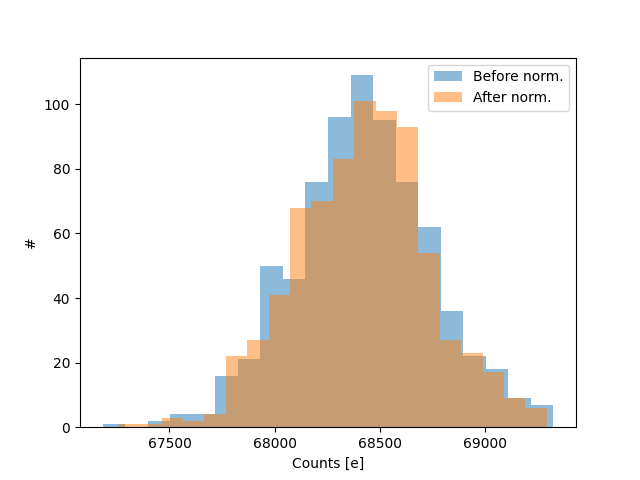

In [21]:
mean_normalization = np.mean(normalization_factors)

plt.figure()
plt.hist(stack[:,100:105,250:255].flatten(), bins=20, alpha=0.5, label='Before norm.')
plt.hist(stack_normalized[:,100:105,250:255].flatten()*mean_normalization, bins=20, alpha=0.5, label='After norm.')
plt.xlabel('Counts [e]')
plt.ylabel('#')
plt.legend()
plt.show()

There is a clear difference between the two distributions (can you quanitfy it)? 
The reason appears clear if we plot the distribution of the normalization factors, and we compare it with the theoretical distribution that they should have if the variations was due to photon noise alone. 

To compute the normal distribution, I assumed $\sigma = \sqrt{(f_{avg})}$  

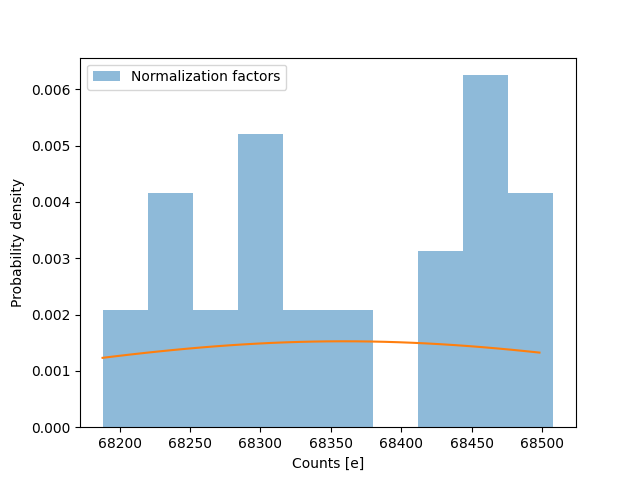

In [22]:
sigma_mean_normalization = np.sqrt(mean_normalization)
x = np.arange(np.amin(normalization_factors), np.amax(normalization_factors), 10)
y = 1./(sigma_mean_normalization * np.sqrt(2 * np.pi)) * \
               np.exp( - (x - mean_normalization)**2 / (2 * sigma_mean_normalization**2) )

plt.figure()
plt.hist(normalization_factors,alpha=0.5, density=True, label='Normalization factors')
plt.plot(x,y)
plt.xlabel('Counts [e]')
plt.ylabel('Probability density')
plt.legend()
plt.show()

It appears clear that the variation in the illumination by the flat lamp is not consistent with photon noise alone. After technical investigation, a fluctuations in the voltage of the lamp has been discovered.

For this reason, we performed the normalization, i.e., removing the variation of illumination with time, before computing the median.